In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Loading original data points

Let $X=\{x_1,...,x_n\} \in \mathbb{R}^p$ be data points,  
where $n$ is the number of points and $p$ is the dimension of points.

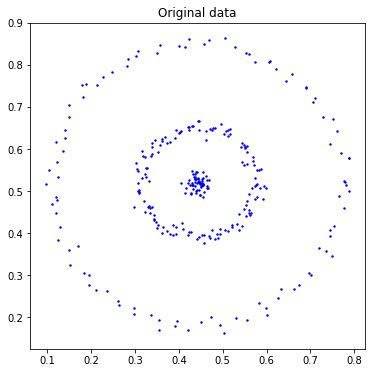

In [2]:
from scipy.io import loadmat

ori = loadmat('Data/Data2.mat')

n = len(ori['data'])       #number of points
p = len(ori['data'][0])    #dimension of points

for i in range(n): plt.scatter(ori['data'][i][0],ori['data'][i][1], s=2, c="blue")
plt.title("Original data")
plt.gcf().set_size_inches(6,6)
plt.show()

## Diffusion map

### First, we explain the diffusion process and define some functions.

#### step 1.  Define a kernel and create the kernel matrix.

Consider Guassian kernel $$ k(x_{i},x_{j}) = \exp(-\frac{\lVert x_{i}-x_{j} \rVert^2}{\sigma_i \sigma_j}) $$
where $$ \sigma_i=\lVert x_i-x_s \rVert^2 $$ and $x_s$ is the $s$'th neighber of point $x_i$.  
Define the kernel matrix $K$, with entries $ K_{ij}=k(x_{i},x_{j}) $.

Note that $K$ is a $n*n$ symmetric matrix, the value of the element in the matrix is between 0 and 1, and is equal to 0 on the diagonal.  
The value of the element is small if two data points $x_i$ and $x_j$, are far away from each other in the data space; and is large if opposite.

In [4]:
def get_K(D, sigma):
    list1=[]

    for i in range(n):
        for j in range(n):
            list1.append( exp(-D[i][j]*D[i][j]/(sigma[i]*sigma[j])) )
    K = array(list1).reshape(n, n)
    
    return K

Note that the connectivity between two data points $x_i$ and $x_j$, is consider as the probability of jumping from $x_i$ to $x_j$ in one step of random walk.
The relation between probability function and kernel function is
$$ p(x,y)=\frac{k(x,y)}{\sum_{y\in X} k(x,y)} $$

Define the diffusion matrix $P$, with entries $ P_{ij}=p(x_{i},x_{j}) $. Note that $P$ is not symmetric and has a discrete sequence of eigenvalues $1=\lambda_0 > \lvert \lambda_1 \rvert \geq \lvert \lambda_2 \rvert \geq \cdots$.

Let $$ D=
\left[
\begin{matrix}
 \sum_{y\in X} k(x_1,y)      &0      & \cdots &0      \\
 0      &\sum_{y\in X} k(x_2,y)      & \cdots &0      \\
 \vdots & \vdots & \ddots & \vdots \\
 0      &0      & \cdots & \sum_{y\in X} k(x_n,y)     \\
\end{matrix}
\right]
$$ be a $n*n$ diagonal matrix, then $ P=D^{-1}K $.

Consider another matrix $Q$, define as $ Q=D^{1/2}P D^{-1/2} $, we have that
1. $Q$ is symmetric.
2. $Q$ has same eigenvalues as $P$.
3. eigenvectors of $Q$, denoted as $e_k$, are multiplied by $D^{-1/2}$ and $D^{1/2}$ to get the right and left eigenvectors of $P$ respectively.

#### step 2. Row normalize the kernel matrix.

It is easier for us to compute the matrix $Q$.  
Since $$ Q=D^{1/2}P D^{-1/2}=D^{1/2}(D^{-1}K) D^{-1/2}=D^{-1/2}K D^{-1/2} $$, 
it means that we should divide entries of $K$ by the product of root number of the sum of the related row and column.

In [3]:
def get_v(K):
    list1=[]
    
    for i in range(n): list1.append( sqrt(sum(K[i])) )
    v = array(list1).reshape(n,1)
    
    return v

In [5]:
from scipy.sparse import csr_matrix

def get_Q(K, v):
    list1=[]
    
    Q = K/(v*v.T)    #v*v.T is a n*n symmetric matrix.
                     #the multiplication and division is applied to each element,
                     #not the matrix operations.
    
    #turn Q into a sparse matrix to speed up calculation
    threshold = 5e-6
    for i in range(n):
        for j in range(n):
            if Q[i][j]>threshold: list1.append(1.)
            else: list1.append(0.)
    a = array(list1).reshape(n, n)
    Q = csr_matrix(Q*a, dtype=float)
    
    return Q

#### step 3. Find eigenvectors and eigenvalues of the diffusion matrix.

Without calculate all eigenvalues and eigenvectors of $Q$, we just need to find the largest $c$ eigenvalues and the corresponding eigenvectors, since $c$ is the largest dimension of diffusion space that we consider.

As we mention earlier, the right and left eigenvectors of $P$ are
$$ \psi_k=D^{-1/2} e_k , \phi_k=D^{1/2} e_k $$ respectively, where $k=1,2,...,c$.

<span style="color:red"> ???

In [6]:
from scipy.sparse.linalg import svds

def get_eig(Q, v, c):
    list1=[]
    list2=[]
    
    [U, S, V] = svds(Q,c+1)    #compute the largest c singular values/vectors for a sparse matrix.
                               #since Q is a real symmetric matrix, singular values and non-negative
                               #eigenvalues coincide.

    eigenvals = flip(S).reshape(c+1,1)
    
    for i in range(n): U[i]=flip(U[i])
    for i in range(n):
        for j in range(c+1):
            list1.append(U[i][j]/U[i][0])    #U[i][0] / v[i]
            list2.append(U[i][j]*U[i][0])
            
    psi = array(list1).reshape(n, c+1)
    phi = array(list2).reshape(n, c+1)

    
    return [psi, phi, eigenvals]

By taking powers of $P$, we increase the number of steps taken, that is, $P_{ij}^{t}$ sum all paths that take $t$ steps from $x_i$ to $x_j$, this is called the diffusion process.

When increasing value $t$, the probability of following a path along the underlying geometric structure of the data set increases, since along the geometric structure, points are dense and therefore highly connected, pathways form along short and high probability jumps.

Now, we define the diffusion distance
$$ D_t(x_i,x_j)^2 = \sum_{u\in X}\lvert p_t(x_i,u)-p_t(u,x_j)\rvert^2 =
\sum_{k=1}^{n}\lvert P_{ik}^t-P_{kj}^t \rvert^2 $$
It is small if there are many high probability paths of taking $t$ steps from one point to another.

#### step 4. Get the diffusion map and treat each row as a point coordinate.

We define a diffusion map $Y$, which maps corrdinates between data and diffusion space, with its column $$ Y_i=
\left[
\begin{matrix}
 p_t(x_i,x_1)  \\
 p_t(x_i,x_2)  \\
 \vdots        \\
 p_t(x_i,x_n)  \\
\end{matrix}
\right]
=
\left[
\begin{matrix}
 \lambda_i^t \psi_i  \\
\end{matrix}
\right]
= P_{i}^t $$
For this map, $$ \lVert Y_i-Y_j \rVert_E^2 = \sum_{u\in X}\lvert p_t(x_i,u)-p_t(x_j,u)\rvert^2 = 
\sum_{k=1}^{n}\lvert P_{ik}^t-P_{kj}^t \rvert^2 = D_t(x_i,x_j)^2 $$
the diffusion distance in data space simply become the Euclidean distance in the diffusion space.

Dimensional reduction is done by neglecting certain dimensions in the diffusion space, since the eigenvalues indicate the importance of each dimension.


<span style="color:red"> We multiply each column by a function of related eigenvalues to increase the effect of the importance of eigenvalues.

In [7]:
def get_Y(eigenvals, c, psi, t):
    list1=[]
    
    if t!=0:
        for i in range(n):
            for j in range(c):
                list1.append(psi[i][j]*pow(eigenvals[j], t))
        Y = array(list1).reshape(n, c)
    else:
        for i in range(n):
            for j in range(c):
                list1.append( psi[i][j+1]*(eigenvals[j+1]/(1-eigenvals[j+1])) )
        Y = array(list1).reshape(n, c)
        
    return Y

### Next, we set some parameters that been required.

D : matrix of Euclidean distance of data points in $\mathbb{R}^p$.  
c : the largest $c$ eigenvalues, that is, the largest dimension we consider.  
t : parameter $t$ in the diffusion process.  
s : parameter $s$ in the Guassian kernel function.  
sigma : a list of $\sigma_i$, which required in the Guassian kernel function.

In [11]:
from scipy.spatial.distance import squareform, pdist
D = squareform(pdist(ori['data']))
c = 10
t = 0
flag_t=0
s = 7

sigma=[]
D_sort = sort(D,1)    # distance of one point to another arrange in descending power
for i in range(n): sigma.append( D_sort[i][s+1] )

### Finally, we conclude the steps above and display the result.

In [12]:
def diffuse(D, sigma, c, t):
    
    K = get_K(D, sigma)
    v = get_v(K)
    Q = get_Q(K, v)
    [psi, phi, eigenvals] = get_eig(Q, v, c)
    Y = get_Y(eigenvals, c, psi, t)

    return Y, eigenvals, psi, phi

In [13]:
Y, eigenvals, psi, phi = diffuse(D, sigma, c, t)

#### Show the fall-off of eigenvalues.

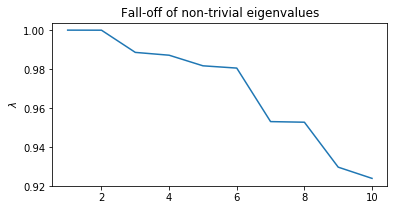

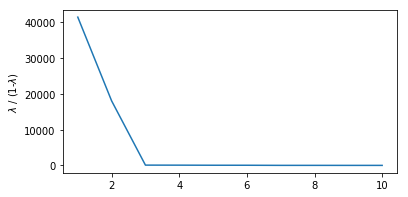

In [14]:
plt.plot(range(1,c+1),eigenvals[1:c+1])
plt.title('Fall-off of non-trivial eigenvalues')
plt.ylabel('$\lambda$')
plt.gcf().set_size_inches(6,3)
plt.show()

if flag_t:
    plt.plot(range(1,c+1), pow(eigenvals[1:c+1], t))
    plt.ylabel('$\lambda$^t')
else:
    plt.plot(range(1,c+1), eigenvals[1:c+1]/(1-eigenvals[1:c+1]) )
    ylabel('$\lambda$ / (1-$\lambda$)')
plt.gcf().set_size_inches(6,3)
plt.show()

#### Show the diffusion space.

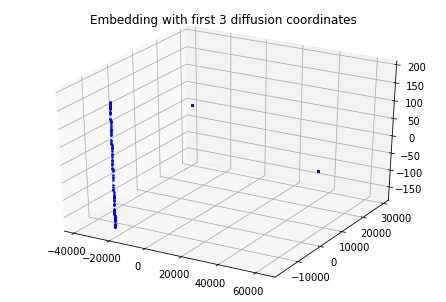

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
for i in range(n): ax.scatter(Y[i][0],Y[i][1],Y[i][2],s=2, c='b')
ax.set_title('Embedding with first 3 diffusion coordinates')
plt.show()

## Clustering using diffusion map

#### Set parameters.

k : number of clusters.  
Niter : number of iterations to repeat the clustering with new IC.  
epsilon : relative distortion.  
phi0 : first left eigenvector of P.

In [17]:
k=3
Niter=100
epsilon=1e-3

list1=[]
for i in range(n): list1.append(phi[i][0])
phi0=array(list1).reshape(n,1)

#### Set functions.

In [18]:
from math import ceil
import random as rnd

def diffusion_kmeans(Y, k, phi0, Niter, epsilon):
    
    d=len(Y[0])
    aD=Inf

    for i in range(Niter):
        tmp_ind = rnd.sample(range(n), k)
        
        list1=[]
        for p in tmp_ind:
            for q in range(d):
                list1.append(Y[p-1][q])
        c_0 = array(list1).reshape(k, d)
    
        idx, c, cindex, D, DX = distortionMinimization(Y, phi0, k, c_0, 0, epsilon)

        if D<aD:
            aD=D
            aDX=DX
            a_idx=idx
            ac=c
    D=aD
    DX=aDX
    idx=a_idx
    C=ac
    
    return idx, C, D, DX

In [19]:
def distortionMinimization(Y, phi0, k, c_0, DspFlag, epsilon):
    list1=[]
    list2=[]
    list3=[]
    
    d=len(Y[0])
    c=c_0
    oldD=Inf
    MaxIter=1000
    
    for i in range(MaxIter):
        for j in range(k):
            for p in range(n):
                for q in range(d):
                    list1.append(Y[p][q]-c[j][q])
            dX = (array(list1).reshape(n,d)).T    #dX=dX.T
            list1.clear()
            
            list2.append(sum(dX.conj()*dX,axis=0))
        DX = (array(list2).reshape(k,n)).T
        list2.clear()
        
        for j in range(n):
            list1.append(min(DX[j]))
            list2.append(argmin(DX[j])+1)
        Dtmp = array(list1).reshape(1,n)
        S = array(list2).reshape(n,1)
        
        list1.clear()
        list2.clear()
        
        ind=[]
        for j in range(k):
            for p in range(n):
                if S[p]==j+1: ind.append(p)
            if len(ind)==0:
                mx = max(Dtmp[0])
                m = argmax(Dtmp[0])
                S[m][0] = j+1
                Dtmp[0][m] = 0
            ind.clear()

        for j in range(k):
            for p in range(n):
                if S[p]==j+1: ind.append(p)
            for p in range(d):
                tempsum=0
                for q in ind:
                    tempsum += phi0[q][0]
                tempsum2=0
                for q in ind:
                    tempsum2 += phi0[q][0]*Y[q][p]/tempsum
                list3.append(tempsum2)
            ind.clear()
        c = array(list3).reshape(k,d)
        
        list3.clear()
        
        D = dot(Dtmp, phi0)
        
        
        """
        #plot results
        
        for j in range(len(D)*len(D[0])):list3.append(Inf)
        oldD = array(list3).reshape(len(D), len(D[0]))
        
        list1.clear()
        list2.clear()
        list3.clear()
        """
        
        
        if (oldD-D)/D < epsilon: break
        oldD=D
        
        
    for j in range(k):
        for p in range(n):
            for q in range(d):
                list1.append(Y[p][q]-c[j][q])
        dX = (array(list1).reshape(n,d)).T    #dX=dX.T
        list1.clear()
  
        list2.append(sum(dX.conj()*dX,axis=0))
        DX = array(list2).reshape(n,1)
        list2.clear()
            
        dummy = min(DX.T[0])
        list3.append( argmin(DX.T[0]) )
    cindex = array(list3).reshape(k,1)
    
    
    return S, c, cindex, D, DX

#### Show the result.

In [20]:
idx, C, ERR, DX = diffusion_kmeans(Y, k, phi0, Niter, epsilon)

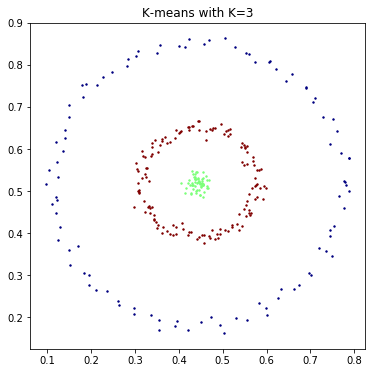

In [22]:
cmap = cm.jet
norm = Normalize(1, k)

for i in range(n):
    plt.scatter(ori['data'][i][0], ori['data'][i][1], s=2, c=cmap(norm(idx[i])) )

plt.title('K-means with K=3')
plt.gcf().set_size_inches(6,6)
plt.show()